# Fitting a model to some lensing observables

The approach used in any parametric SL reconstruction consists of finding the best values of a set of parameters to describe a lens. The modeler has to choose a model family, i.e. by choosing a class of density profilee to work with. The profile brings in its own parameters. For example, the singular isothermal profile is fully specified by the lens velocity dispersion. If one chooses to use the softened isothermal profile, he will have an addional parameter, i.e. the core size. Other parameters define the shape of the lens and its orientation (e.g. the ellipticity and the position angle), and several times even the coordinates of the center of the lens are free parameters.

How does the modeler choose the best-fit parameters? He needs to use the lensing observables as constraints. There are three kinds of constraints:
* positional, i.e. the image locations. This is the most common kind of constraint. The location of the multiple images of a given source probe the deflection field of the lens, i.e. the derivative of the lensing potential;
* shape, i.e. the distortion of the lensed images, their sizes, and fluxes. They probe the magnification, i.e. the second derivatives of the potential;
* time: when it is possible to measure them, time delays between the images. They probe the gravitational potential.

Clearly, the potential is a much smoother function than the magnification. Thus, time delays are only weakly affected by substructures and are easier to fit. On the contrary, the lens magnification is a much noiser quantity. It is no surprise, indeed, that smooth potentials can hardly reproduce the flux ratios between multiple images of the same source.

## An example of how parametric models work

To illustrate how a parametric method for lens inversion works, we consider the case of a simple lens and we assume to have positional constraints from the observation of a set of multiple images.

In order to implement the penalty function, we have to be able to solve numerically the lens equation for arbitrary source positions. Therefore, we begin discussing how to perform this operation.

### Finding multiple images

Finding multiple images of any source lensed by arbitrary mass distributions requires using numerical methods. One common algorithm is described in Schneider, Ehlers & Falco (1992).

The method consists of dividing each cell in the image plane into two triangles. Each triangle, when mapped onto the source plane, remains a triangle, i.e. a convex figure. The solutions of the lens equation can be found by searching the triangles on the source plane which contain the source. 

To check if a point is contained into one of the triangles, one can use barycentric coordinates. In the context of a triangle whose vertices are given by the points $\vec y_1$, $\vec y_2$, and $\vec y_3$, any point inside the triangle can be written as
$$
\vec y = \lambda_1\vec y_1+\lambda_2\vec y_2+\lambda_3 \vec y_3 \;,
$$
where $\lambda_1$, $\lambda_2$, and $\lambda_3$ are three positive numbers satisfying $\lambda_1+\lambda_2+\lambda_3 =1$.
The condition for $\vec y$ being interior to the triangle is thus that each $\lambda_i$ satisfy the condition
$$
0\leq \lambda_i \leq 1 \;.
$$
One can show that
$$
\lambda_1=\frac{(y_{2,2}-y_{3,2})(y_1-y_{3,1})+(y_{3,1}-y_{2,1})(y_2-y_{3,2})}{(y_{2,2}-y_{3,2})(y_{1,1}-y_{3,1})+(y_{3,1}-y_{2,1})(y_{1,2}-y_{3,2})}
$$
and
$$
\lambda_2=\frac{(y_{3,2}-y_{1,2})(y_1-y_{3,1})+(y_{1,1}-y_{3,1})(y_2-y_{3,2})}{(y_{2,2}-y_{3,2})(y_{1,1}-y_{3,1})+(y_{3,1}-y_{2,1})(y_{1,2}-y_{3,2})} \;,
$$
while $\lambda_3=1-\lambda_1-\lambda_2$.

The approximated position of the images is then given by the location of the corresponding triangle on the image plane.

This algorithm has been implemented in the function ```find_images``` of the ```gen_lens``` class.

First of all, we produce a lens. We use the PSIE model to generate a lens. We may even add substructures.

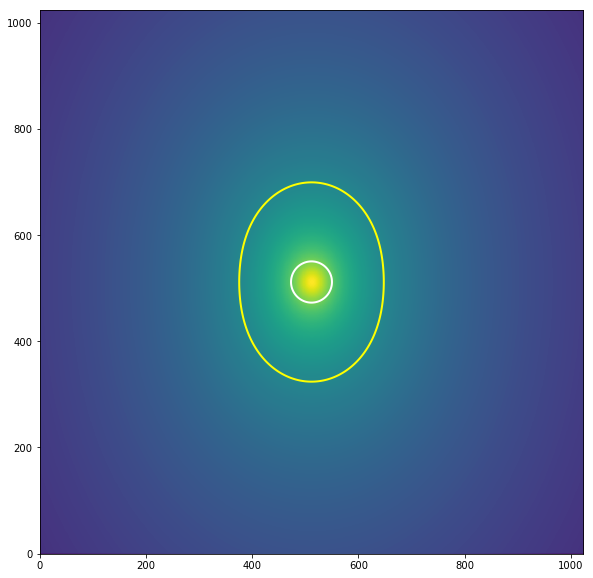

In [23]:
from mynewdeflector import *
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline
"""
Main lens:
"""
kwargs={'theta_c': 5.0, 'norm': 30.0, 'ell': 0.1}
size=200.0
npix=1024.0
main_lens=psie(size=size,npix=npix,**kwargs)

"""
substructures
"""
n_pert=0

xsub=(np.random.random_sample(n_pert)-0.5)*size
ysub=(np.random.random_sample(n_pert)-0.5)*size

fsub=np.random.random_sample(n_pert)
pa=np.random.random_sample(n_pert)*2.0*np.pi

pot=main_lens.pot
for i in range(n_pert):
    kwargs={'theta_c': 0.0, 'norm': 0.5, 'ell': 0.0, 'pa': pa[i]}
    sub_lens=psie(x0=xsub[i],y0=ysub[i],size=size,npix=npix,**kwargs)
    pot=pot+sub_lens.pot

df=deflector_from_potential(pot=pot,size=size,npix=npix)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(df.convergence(),origin='low',norm=LogNorm())
g1,g2=df.shear()
lambdat=1.0-df.convergence()-np.sqrt(g1*g1+g2*g2)
lambdar=1.0-df.convergence()+np.sqrt(g1*g1+g2*g2)
cst=ax.contour(lambdat,levels=[0.0],colors='yellow',linewidths=2)
ax.imshow(lambdar,origin='low',alpha=0)
csr=ax.contour(lambdar,levels=[0.0],colors='white',linewidths=2)

Then, we select a source to produce a mock observation of a family of multiple images.

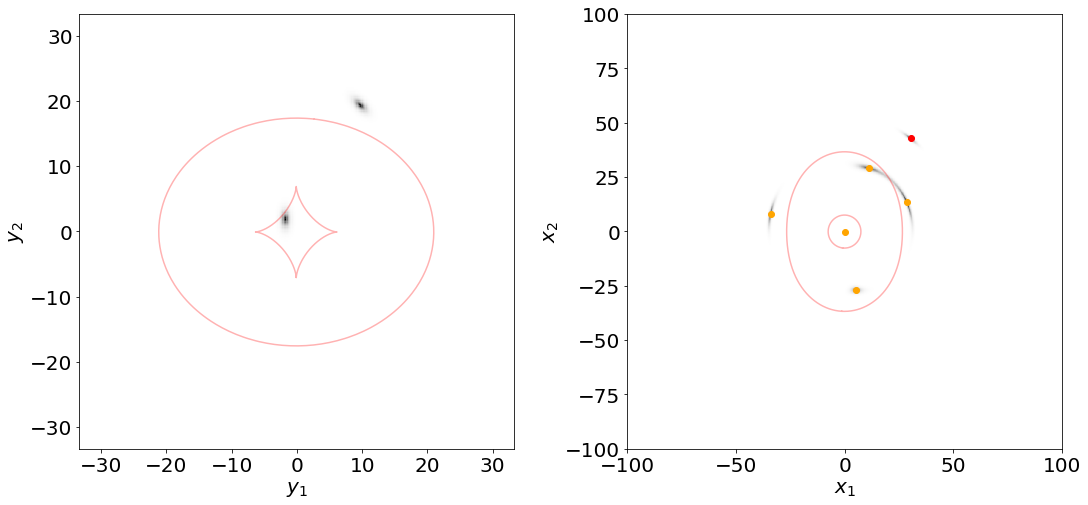

In [24]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
#main_lens.clines(ax=ax[0])
#main_lens.caustics(lt='--',ax=ax[1],color='blue')


df.clines(ax=ax[1],alpha=0.3)
#ax[0].contour(main_lens.detA(),linestyles='dashed',levels=[0.0],
#              extent=[-size/2.,size/2.,-size/2.,size/2.],
#            colors='blue')
df.caustics(ax=ax[0],alpha=0.3)

        
ax[0].set_xlim([-size/6.,size/6.])
ax[0].set_ylim([-size/6.,size/6.])
ax[1].set_xlim([-size/2.,size/2.])
ax[1].set_ylim([-size/2.,size/2.])
                      
ax[1].set_xlabel('$x_1$',fontsize=20)
ax[1].set_ylabel('$x_2$',fontsize=20)
ax[0].set_xlabel('$y_1$',fontsize=20)
ax[0].set_ylabel('$y_2$',fontsize=20)
for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=20)
    ax[i].yaxis.set_tick_params(labelsize=20)
    ax[i].set_aspect('equal')

kwargs={'q': 0.5,'re': 1.0, 'pa': np.pi, 'n': 1,'ys1': -1.7, 'ys2': 1.9}
se_unlensed=sersic(size,npix,**kwargs)
se=sersic(size,npix,gl=df,**kwargs)
xi1,xi2=df.find_images(kwargs['ys1'],kwargs['ys2'])

image_lensed=se.image
image_unlensed=se_unlensed.image
#fig,ax=plt.subplots(1,2,figsize=(18,8))
#ax[0].imshow(se_unlensed.image,origin='lower',extent=[-se.size/2,se.size/2,-se.size/2,se.size/2],cmap='gray_r',zorder=1)
#ax[1].imshow(se.image,origin='lower',extent=[-se.size/2,se.size/2,-se.size/2,se.size/2],cmap='gray_r',zorder=1) 

kwargs={'q': 0.5,'re': 1.0, 'pa': np.pi/4, 'n': 1,'ys1': 9.8, 'ys2': 19.4}
se_unlensed=sersic(size,npix,**kwargs)
se=sersic(size,npix,gl=df,**kwargs)
xe1,xe2=df.find_images(kwargs['ys1'],kwargs['ys2'])

image_lensed=image_lensed+se.image
image_unlensed=image_unlensed+se_unlensed.image
#fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[0].imshow(image_unlensed,origin='lower',extent=[-se.size/2,se.size/2,-se.size/2,se.size/2],cmap='gray_r',zorder=1)
ax[1].imshow(image_lensed,origin='lower',extent=[-se.size/2,se.size/2,-se.size/2,se.size/2],cmap='gray_r',zorder=1) 
ax[1].plot(xe1,xe2,'o',color='red')
ax[1].plot(xi1,xi2,'o',color='orange')
y1,y2=df.map_back(xi1,xi2)

In the right panel, we show the lensed images and mark their positions with orange dots. The positions of these dots was determined using the method outlined above. Clearly, we are solving the lens equation correctly! 


### Delensing the images

Now, forget to know what the lens is. We make a guess about how the lens should be and use this "guessed" model to delens the multiple image system. 

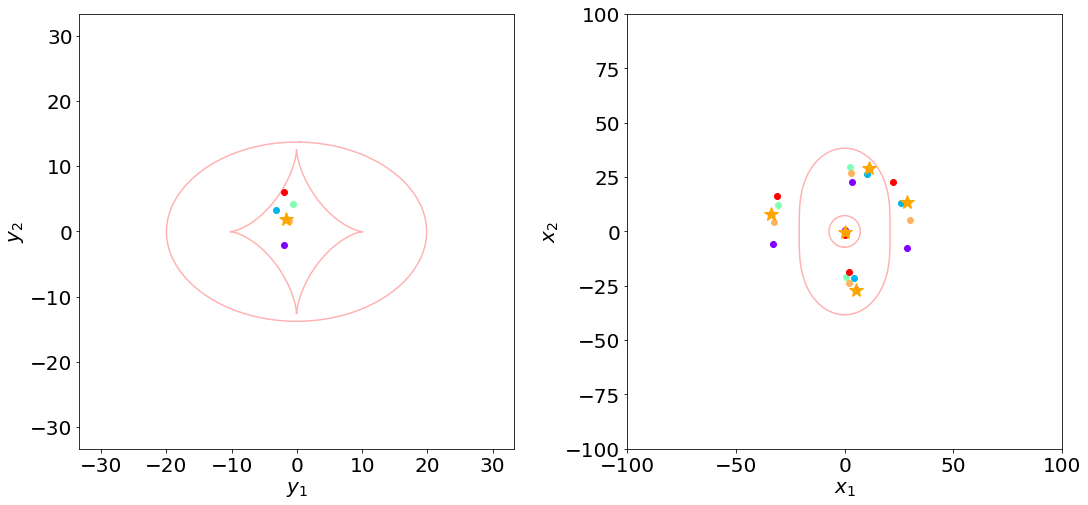

In [46]:
from matplotlib.pyplot import cm 

"""
Main lens:
"""
kwargs={'theta_c': 5.3, 'norm': 26.0, 'ell': 0.18}
#kwargs={'theta_c': 5.0, 'norm': 30.0, 'ell': 0.1}
size=200.0
npix=2048.0
df1=psie(size=size,npix=npix,**kwargs)

fig,ax=plt.subplots(1,2,figsize=(18,8))
df1.clines(ax=ax[1],alpha=0.3)
df1.caustics(ax=ax[0],alpha=0.3)

kwargs={'ys1': -1.7, 'ys2': 1.9}

        
ax[0].set_xlim([-size/6.,size/6.])
ax[0].set_ylim([-size/6.,size/6.])
ax[1].set_xlim([-size/2.,size/2.])
ax[1].set_ylim([-size/2.,size/2.])
                      
ax[1].set_xlabel('$x_1$',fontsize=20)
ax[1].set_ylabel('$x_2$',fontsize=20)
ax[0].set_xlabel('$y_1$',fontsize=20)
ax[0].set_ylabel('$y_2$',fontsize=20)
for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=20)
    ax[i].yaxis.set_tick_params(labelsize=20)
    ax[i].set_aspect('equal')


y1,y2=df1.map_back(xi1,xi2)
color=iter(cm.rainbow(np.linspace(0,1,y1.size)))
for i in range(len(y1)):
    c=next(color)
    xe1,xe2=df1.find_images(y1[i],y2[i])
    ax[1].plot(xe1,xe2,'o',color=c)
    ax[0].plot(y1[i],y2[i],'o',color=c)
    

ax[1].plot(xi1,xi2,'*',color='orange',markersize=15)
ax[0].plot(kwargs['ys1'],kwargs['ys2'],'*',color='orange',markersize=15)


Being the model we have chosen different from the true lens, each image is mapped on a different source on the source plane. We use dots of different colors in the left panel to show where each of the multiple images ends up. The star shows the true position of the source. 

In the right panel, we re-map each source on the lens plane. For each oberved image, we have now a number of predicted image positions (because each of the colored sources in the left panel is treated as an independent source). 

The goal is to find the model parameters that minimize the difference between the predicted and the observed image positions. Therefore, one can define a penalty function, for example by computing the distance between the closest predicted image and the given observed image. Repeating this operation for each image and summing the distances in quadrature, we obtain a $\chi^2$ function, which has to be minimized to give the best-fit lens model.

In [47]:
chi2=0.0
sigma=0.1
for i in range(len(xi1)):
    dist=(xe1-xi1[i])**2+(xe2-xi2[i])**2
    inde=np.argsort(dist)
    chi2=chi2+dist[inde[0]]/sigma
    
print (chi2)

2777.91096091


 

One other possibility is to compute the average source position in the source plane, and map the average source onto the lens plane:

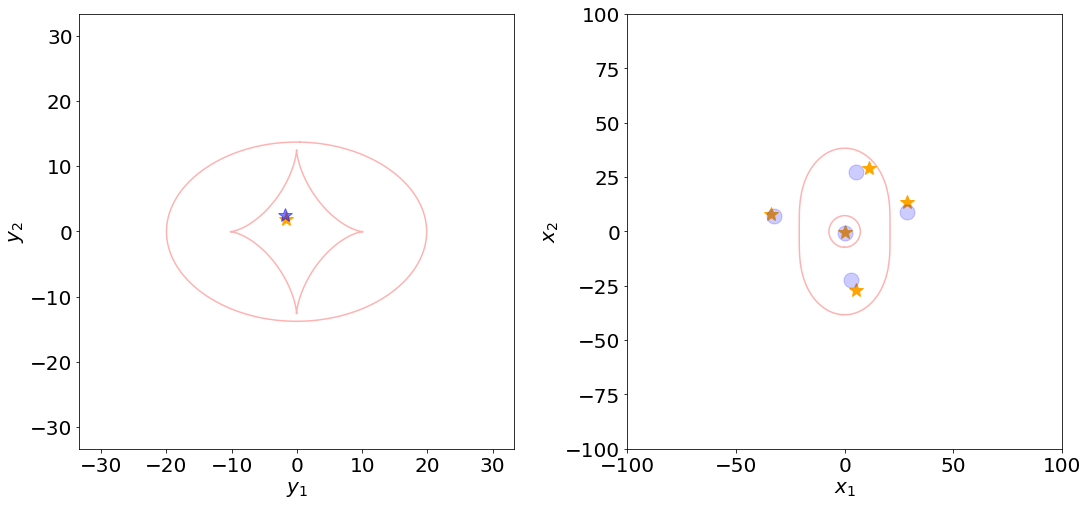

In [48]:
y1_mean,y2_mean=y1.mean(),y2.mean()
xe1,xe2=df1.find_images(y1_mean,y2_mean)
fig,ax=plt.subplots(1,2,figsize=(18,8))
df1.clines(ax=ax[1],alpha=0.3)
df1.caustics(ax=ax[0],alpha=0.3)

        
ax[0].set_xlim([-size/6.,size/6.])
ax[0].set_ylim([-size/6.,size/6.])
ax[1].set_xlim([-size/2.,size/2.])
ax[1].set_ylim([-size/2.,size/2.])
                      
ax[1].set_xlabel('$x_1$',fontsize=20)
ax[1].set_ylabel('$x_2$',fontsize=20)
ax[0].set_xlabel('$y_1$',fontsize=20)
ax[0].set_ylabel('$y_2$',fontsize=20)
for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=20)
    ax[i].yaxis.set_tick_params(labelsize=20)
    ax[i].set_aspect('equal')
    
ax[1].plot(xi1,xi2,'*',color='orange',markersize=15)
ax[0].plot(kwargs['ys1'],kwargs['ys2'],'*',color='orange',markersize=15)

ax[1].plot(xe1,xe2,'o',color='blue',markersize=15,alpha=0.2)
ax[0].plot(y1_mean,y2_mean,'*',color='blue',markersize=15,alpha=0.5)

In [49]:
chi2=0.0
sigma=0.1
associated=np.zeros(len(xi1))
for i in range(len(xi1)):
    dist=(xe1-xi1[i])**2+(xe2-xi2[i])**2
    inde=np.argsort(dist)
    associated[i]=np.int(inde[0])
    chi2=chi2+dist[inde[0]]/sigma
    
print (chi2)

863.504344948


/Users/massimo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


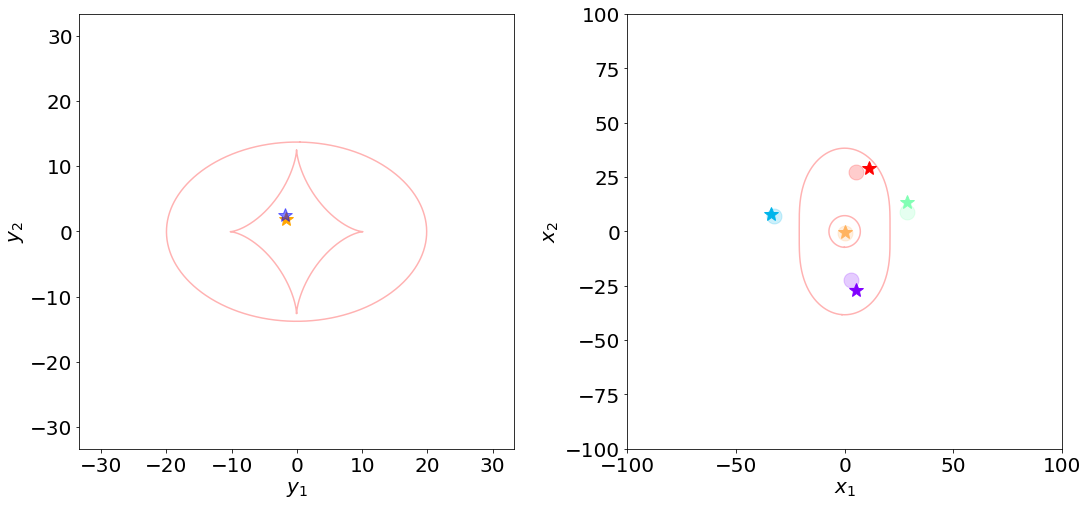

In [50]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
df1.clines(ax=ax[1],alpha=0.3)
df1.caustics(ax=ax[0],alpha=0.3)

        
ax[0].set_xlim([-size/6.,size/6.])
ax[0].set_ylim([-size/6.,size/6.])
ax[1].set_xlim([-size/2.,size/2.])
ax[1].set_ylim([-size/2.,size/2.])
                      
ax[1].set_xlabel('$x_1$',fontsize=20)
ax[1].set_ylabel('$x_2$',fontsize=20)
ax[0].set_xlabel('$y_1$',fontsize=20)
ax[0].set_ylabel('$y_2$',fontsize=20)
for i in range(2):
    ax[i].xaxis.set_tick_params(labelsize=20)
    ax[i].yaxis.set_tick_params(labelsize=20)
    ax[i].set_aspect('equal')
    
color=iter(cm.rainbow(np.linspace(0,1,y1.size)))
for i in range(len(xi1)):
    c=next(color)
    ax[1].plot(xi1[i],xi2[i],'*',color=c,markersize=15)
    ax[1].plot(xe1[associated[i]],xe2[associated[i]],'o',color=c,markersize=15,alpha=0.2)
ax[0].plot(kwargs['ys1'],kwargs['ys2'],'*',color='orange',markersize=15)
ax[0].plot(y1_mean,y2_mean,'*',color='blue',markersize=15,alpha=0.5)

Then, a $\chi^2$ function can be defined as above.

Of course, if several families of multiple images are avalaible, the $\chi^2$ can be extended to incorporate the contribution from each family.

This kind of minimization procedure is called "image plane optimization", because it compares observed and predicted positions of the images. It has the disadvantage that it requires to solve numerically the lens equation, which is computationally demanding.

Another approach consists of performing the optimization on the source plane. In this case, the goal is to find the model which minimizes the scatter of the image positions mapped back to the source plane. In other words:

In [51]:
sigma_S=1 # should be something related to sigma and magnification
chi2=(((y1 - y1.mean())**2**2+(y2 - y2.mean()))/sigma_S**2).sum()
print (chi2)

5.47659572943


### Other observables

Once the expected image location is known, several properties of the lensed images can be derived. For example, the flux (or the magnification) at the image location is:

In [52]:
# magnification
mu_predicted=df.imageMagnification(xe1[associated.astype(int)],xe2[associated.astype(int)])
mu_observed=df.imageMagnification(xi1,xi2)
print (1.0/mu_predicted)
print (1.0/mu_observed)

[ -1.8050466    5.34724812  11.84077518   0.03306635  -3.5714902 ]
[-3.35459778  4.56210911  9.14149601  0.03193361 -8.50721325]


In [53]:
# time delays
td_predicted=df.imageTimeDelay(xe1[associated.astype(int)],xe2[associated.astype(int)],y1.mean(),y2.mean())
td_observed=df.imageTimeDelay(xi1,xi2,kwargs['ys1'],kwargs['ys2'])
print (td_predicted-td_predicted.min())
print (td_observed-td_observed.min())

[ 296.84153066  446.30561898  439.21314751    0.          297.06486907]
[ 412.62637347  501.24742282  485.31438505    0.          416.5941515 ]
